<a href="https://colab.research.google.com/github/manoushpajouh/Vassar-Crowdmeter/blob/main/AI_Image_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Implement a house number recognition model. The dataset on which you will train your model is the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). There are two variants of the dataset: one with the full numbers and one containing cropped images corresponding to the digits 0-9. You're going to work with the latter. Each image is a 32x32 RGB image. The task is to classify each image into one of the 10 classes corresponding to the digits. The desired accuracy you should achieve is **90%**. Additionally, you'll implement data augmentation and observe its effects on the training process.

Work with the PyTorch library.
Prepare to use Pytorch Lightning or adapt to pure Pytorch.

The objectives are to
1. implement a convolutional neural network given a pre-defined architecture
2. implement data augmentation


In [ ]:
! pip install lightning

# Implementation


In [ ]:
# imports

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import lightning as pl

# for visualization purposes
import matplotlib.pyplot as plt

In [ ]:
# fix random seed
pl.seed_everything(100)

INFO: Seed set to 100
INFO:lightning.fabric.utilities.seed:Seed set to 100


100

In [ ]:
# load the datasets
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True)    # <------ ! don't use this dataset for development !

100%|██████████| 182M/182M [00:04<00:00, 39.5MB/s]


100%|██████████| 64.3M/64.3M [00:01<00:00, 47.6MB/s]


Label: 5


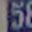

In [ ]:
# visualize a random image and its label
index = torch.randint(0, len(train_dataset), (1,)).item()
img, label = train_dataset[index]
print(f"Label: {label}")
display(img)

In [ ]:
# transform the datasets so that we can work with it in pytorch
dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset.transform = dataset_transform
test_dataset.transform = dataset_transform

In [ ]:
# convert the datasets into DataLoaders and split into training and validation sets
from torch.utils.data import DataLoader, random_split

dev_length = int(0.2*len(train_dataset))
train, dev = random_split(train_dataset, [int(len(train_dataset) - dev_length), dev_length])# TODO split the training dataset; I suggest the proportion 0.8 for train and 0.2 for dev
train_loader = DataLoader(train, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


## NN module

Below is a structure of the neural network. It has three convolutional layers, each with the ReLU activation function. Each convolutional layer is then passed through a max-pooling layer (this basically picks the maximum value in each 2x2 patch of the image, reducing the size by half). On top of the third convolutional layer, there are two fully-connected layers which yield the final prediction.

The convolutions have been defined.

The first convolution should have a kernel of size 3x3. We want to use padding. The number of input channels should correspond to the number of channels in the input images (they are RGB images, there is no alpha channel).

The second and third convolutional layers also have a kernel of size 3x3. We want to use padding.

Refer to the documentation used to fill out the parameters correctly: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

In [ ]:
input_channels = 3              # input channel is 3 because rgb image (channel 1 = r, 2=g, 3=b)
kernel_size_conv1 = (3, 3)      # kernel size is 3x3 and defined as a tuple
kernel_size_conv2 = (3, 3)      # same as above
kernel_size_conv3 = (3, 3)      # same as above
padding_conv1 = 1               # padding should be 1 (same padding) in order for the kernel to work
padding_conv2 = 1               # same as above
padding_conv3 = 1               # same as above
learning_rate = 0.001            # origignally set to 0.01, randomly chosen by user, may be updated later

class SVHNCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size_conv1, padding=padding_conv1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size_conv2, padding=padding_conv2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size_conv3, padding=padding_conv3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        # calculate loss using a suitable loss function
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        # calculate loss using a suitable loss function
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)
        self.log("val_loss", val_loss)

    def test_step(self, batch, batch_idx):
        # calculate loss and accuracy
        x, y = batch
        y_hat = self(x)
        #did not have same variable from lecture --> googled what to do instead
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        test_loss = self.criterion(y_hat, y)
        self.log("test_loss", test_loss)
        self.log("accuracy", accuracy)

    def configure_optimizers(self):
        # define a suitable optimizer
        return optim.Adam(self.parameters(), lr=self.learning_rate)     #optim.SGD(self.parameters(), lr=self.learning_rate)



Since we are comparing models trained on two datasets of different sizes, we defined the number of training steps instead of the number of epochs. (Defining the number of epochs would mean that the model with the larger training dataset is trained on more examples in total, meaning that the comparison wouldn't be fair. Setting the number of training steps ensures that both models see the same total number of examples.)

The number of training steps is set to the length of one of the datasets multiplied by the number of epochs you want to train for to approximate setting just the max_epochs parameter.

In [ ]:
max_steps = len(train_loader) * 10   # set a suitable value of max_steps: len x epoch number (start w 10, change later)

In [ ]:
trainer = pl.Trainer(max_steps=max_steps, accelerator="gpu")        #accelerator will transfer your data onto the gpu

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
model1 = SVHNCNN()
# train model1 on the train_loader data; validate on dev_loader
trainer.fit(model1, train_dataloaders=train_loader, val_dataloaders=dev_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 896    | train
1 | pool      | MaxPool2d        | 0      | train
2 | conv2     | Conv2d           | 18.5 K | train
3 | conv3     | Conv2d           | 36.9 K | train
4 | fc1       | Linear           | 65.6 K | train
5 | fc2       | Linear           | 650    | train
6 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=9160` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=9160` reached.


## Data augmentation

In this section, you will try to augment the dataset. You will take the `train` subset of the original dataset, apply some transforms to it and mix it with the original untransformed data.

You can see the list of available transforms here: [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html). I recommend trying, for example, `RandomHorizontalFlip` or `RandomRotation`.

In [ ]:
import copy
from torch.utils.data import ConcatDataset

train_aug = copy.deepcopy(train)
augmentation_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),         # normalize data
    transforms.RandomRotation(10)           # transform dataset with changed hue


])
train_aug.dataset.transforms = augmentation_transforms
train_aug_loader = DataLoader(ConcatDataset([train, train_aug]), batch_size=64, shuffle=True)    # we combined the augmented and unaugmented datasets

In [ ]:
# fix random seed
pl.seed_everything(100)

INFO: Seed set to 100
INFO:lightning.fabric.utilities.seed:Seed set to 100


100

In [ ]:
trainer2 = pl.Trainer(max_steps=max_steps, accelerator="gpu")        #initialize a second trainer
model2 = SVHNCNN()
# train model2 on the train_aug_loader data; validate on dev_loader
trainer2.fit(model2, train_dataloaders=train_aug_loader, val_dataloaders=dev_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 896    | train
1 | pool      | MaxPool2d        | 0      | train
2 | conv2     | Conv2d           | 18.5 K | train
3 | conv3     | Conv2d           | 36.9 K | train
4 | fc1       | Linear           | 65.6 K | train
5 | fc2       | Linear           | 650    | train
6 | criterion | CrossEntropyLoss | 0      | train
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=9160` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=9160` reached.


In [ ]:
# test both your models on test_loader
# don't use test_loader before this step!
trainer.test(model1, test_loader)
trainer2.test(model2, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9034649729728699     │
│         test_loss         │    0.37423375248908997    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.892708957195282     │
│         test_loss         │    0.39696264266967773    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.39696264266967773, 'accuracy': 0.892708957195282}]

# Discussion

In the cell below, briefly answer the following questions:

1. What transforms did you use to augment the data? Why did you pick those? What are the differences between the models trained on unaugmented and augmented data? Do you think the data augmentation helped? Why or why not? (1.5 points total)

2. What is the total size of the model? (Hint: Pytorch tells you this value when you start training it.) (0.5 points)



*italicized text*

When augmenting the data, I originally changed the hue of the data image samples. This is, at first, because the only things I saw plausible for augmentation had to do with color or brightness. This is because any sort of reflection or rotation could change the number that the LLM is trying to label. This is why the one with augmented data has a slightly lower accuracy rate, despite being trained on double as much data as that of the one with unaugmented data. Data augmentation did not help in this case because, with the way I augmented it, it ended up confusing the model.

The total size of the model is said to be "0.490     Total estimated model params size (MB)" with "122 K     Trainable params" according to the stats listed when training the model.
